<a href="https://www.kaggle.com/code/ardaorcun/salinas-hsi?scriptVersionId=126665195" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv
from scipy.io import loadmat
from plotly.offline import init_notebook_mode
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import spectral

init_notebook_mode(connected=True)



In [2]:
X=loadmat('../input/salinas/salinas_corrected.mat')['salinas_corrected']
y=loadmat('../input/salinas/salinas_gt.mat')['salinas_gt']

In [3]:
test_ratio=0.8
pixelsize=25

In [4]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [5]:
X.shape, y.shape

((512, 217, 204), (512, 217))

In [6]:
X,pca=applyPCA(X,numComponents=15)
X.shape

(512, 217, 15)

In [7]:
X, y = createImageCubes(X, y, windowSize=25)

X.shape, y.shape

((54129, 25, 25, 15), (54129,))

In [8]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((10825, 25, 25, 15), (43304, 25, 25, 15), (10825,), (43304,))

In [9]:
Xtrain, Xvalid, ytrain, yvalid = splitTrainTestSet(Xtrain, ytrain, 0.3333)

Xtrain.shape, Xvalid.shape, ytrain.shape, yvalid.shape

((7217, 25, 25, 15), (3608, 25, 25, 15), (7217,), (3608,))

In [10]:
Xtrain = Xtrain.reshape(-1, pixelsize, pixelsize, 15, 1)
Xtrain.shape

(7217, 25, 25, 15, 1)

In [11]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(7217, 16)

In [12]:
Xvalid = Xvalid.reshape(-1, pixelsize, pixelsize, 15, 1) 
Xvalid.shape

(3608, 25, 25, 15, 1)

In [13]:
yvalid=np_utils.to_categorical(yvalid)
yvalid.shape

(3608, 16)

In [14]:
input_layer=Input((25,25,15,1))
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
print(conv_layer3.shape)
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)
flatten_layer = Flatten()(conv_layer4)
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=16, activation='softmax')(dense_layer2)

(None, 19, 19, 3, 32)


In [15]:
model=Model(inputs=input_layer,outputs=output_layer)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25, 25, 15, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 23, 23, 9, 8)      512       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 21, 21, 5, 16)     5776      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 19, 19, 3, 32)     13856     
_________________________________________________________________
reshape (Reshape)            (None, 19, 19, 96)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 17, 17, 64)        55360     
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0     

In [16]:
adam=Adam(learning_rate=0.001,decay=1e-06)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [17]:
filepath = "best-model.hdf5"
metric='acc'
checkpoint=ModelCheckpoint(filepath=filepath,monitor=metric,verbose=1,save_best_only=True,mode='max')
callback_list=[checkpoint]

In [18]:
history=model.fit(x=Xtrain,y=ytrain,validation_data=(Xvalid,yvalid),batch_size=256,epochs=20,callbacks=callback_list)

Epoch 1/20
29/29 [==============================] - 29s 969ms/step - loss: 0.9925 - accuracy: 0.6808 - val_loss: 0.1104 - val_accuracy: 0.9557
Epoch 2/20
29/29 [==============================] - 28s 953ms/step - loss: 0.1299 - accuracy: 0.9570 - val_loss: 0.0497 - val_accuracy: 0.9781
Epoch 3/20
29/29 [==============================] - 28s 957ms/step - loss: 0.0739 - accuracy: 0.9780 - val_loss: 0.0084 - val_accuracy: 0.9972
Epoch 4/20
29/29 [==============================] - 28s 956ms/step - loss: 0.0315 - accuracy: 0.9907 - val_loss: 0.0060 - val_accuracy: 0.9989
Epoch 5/20
29/29 [==============================] - 27s 938ms/step - loss: 0.0356 - accuracy: 0.9920 - val_loss: 0.0120 - val_accuracy: 0.9972
Epoch 6/20
29/29 [==============================] - 28s 957ms/step - loss: 0.0308 - accuracy: 0.9917 - val_loss: 7.5369e-04 - val_accuracy: 1.0000
Epoch 7/20
29/29 [==============================] - 28s 957ms/step - loss: 0.0089 - accuracy: 0.9976 - val_loss: 1.7235e-04 - val_accuracy

In [19]:
model.save("best-model1.hdf5")

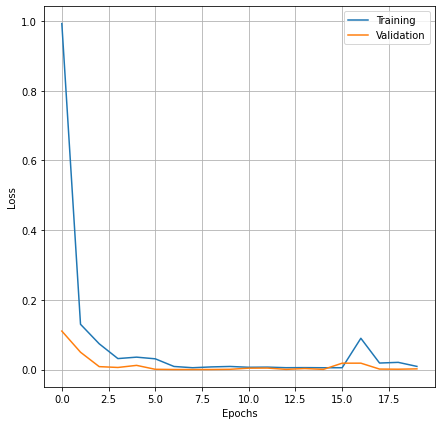

In [20]:
plt.figure(figsize=(7,7)) 
plt.grid() 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss') 
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right') 
plt.savefig("loss_curve.pdf") 
plt.show()



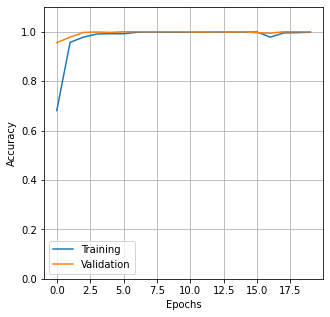

In [21]:
plt.figure(figsize=(5,5)) 
plt.ylim(0,1.1) 
plt.grid() 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy') 
plt.xlabel('Epochs') 
plt.legend(['Training','Validation']) 
plt.savefig("acc_curve.pdf") 
plt.show()

In [22]:
model.load_weights=("best-model1.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


In [23]:
Xtest=Xtest.reshape(-1,pixelsize,pixelsize,15,1)
Xtest.shape

(43304, 25, 25, 15, 1)

In [24]:
ytest=np_utils.to_categorical(ytest)
ytest.shape

(43304, 16)

In [25]:
Y_pred_test=model.predict(Xtest)
Y_pred_test=np.argmax(Y_pred_test,axis=1)
classification= classification_report(np.argmax(ytest,axis=1),Y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1607
           1       0.99      1.00      1.00      2981
           2       1.00      1.00      1.00      1581
           3       1.00      1.00      1.00      1115
           4       1.00      1.00      1.00      2142
           5       1.00      1.00      1.00      3167
           6       1.00      1.00      1.00      2863
           7       1.00      1.00      1.00      9017
           8       1.00      1.00      1.00      4963
           9       1.00      1.00      1.00      2622
          10       1.00      0.99      0.99       854
          11       1.00      1.00      1.00      1542
          12       0.99      1.00      1.00       733
          13       1.00      1.00      1.00       856
          14       1.00      1.00      1.00      5815
          15       1.00      1.00      1.00      1446

    accuracy                           1.00     43304
   macro avg       1.00   

In [26]:
import time
def AA_andEachClassAccuracy(confusion_matrix):
    counter= confusion_matrix[0]
    list_diag= np.diag(confusion_matrix)
    list_raw_sum= np.sum(confusion_matrix,axis=1)
    each_acc=np.nan_to_num(truediv(list_diag,list_raw_sum))
    average_acc=np.mean(each_acc)
    return each_acc, average_acc
def reports(X_test,y_test,name):
    start=time.time()
    Y_pred=model.predict(X_test)
    y_pred=np.argmax(Y_pred,axis=1)
    end=time.time()
    print(end-start)
    target_names= ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    classification=classification_report(np.argmax(y_test,axis=1),y_pred,target_names=target_names)
    oa=accuracy_score(np.argmax(y_test,axis=1),y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [27]:
dataset='SU'
import os 
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

51.897263526916504
1354/1354 [==============================] - 51s 37ms/step - loss: 0.0028 - accuracy: 0.9993


In [28]:
def Patch(data,height_index,width_index):
    height_slice=slice(height_index,height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [29]:
X=loadmat('../input/salinas/salinas_corrected.mat')['salinas_corrected']
y=loadmat('../input/salinas/salinas_gt.mat')['salinas_gt']

In [30]:
height=y.shape[0]
weidth=y.shape[1]
PATCH_SIZE=25
numComponents=15

In [31]:
X,pca=applyPCA(X,numComponents=numComponents)


In [32]:
X=padWithZeros(X,PATCH_SIZE//2)


In [33]:
outputs=np.zeros((height,weidth))
for i in range (height):
    for j in range (weidth):
        target=int(y[i,j])
        if target==0:
            continue
        else:
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction=(model.predict(X_test_image))
            prediction=np.argmax(prediction,axis=1)
            outputs[i][j]=prediction+1

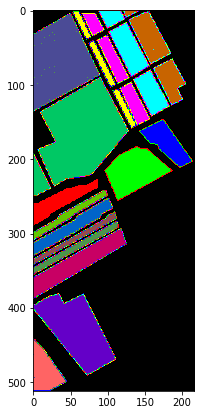

In [34]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))


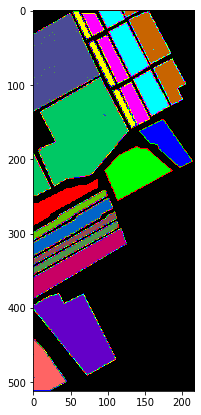

In [35]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))






In [36]:
spectral.save_rgb("prediction2.jpg", outputs.astype(int), colors=spectral.spy_colors)
